In [ ]:
! pip install h3==3.7.7
! pip install matplotlib
! pip install contextily

In [1]:
import h3.api.numpy_int as h3
import pandas as pd
from pyarrow import parquet
import shapely
from shapely.geometry import Polygon
from shapely.ops import transform
import geopandas as gpd
import contextily
import matplotlib.pyplot as plt

In [2]:
signal_name = "temperature_max"
path = "../data/temperature_max"
h3_partition=4
h3_resolution=6

percentiles = [50]
scenarios = ["ssp126"]
return_periods = [100]
years = [2050]

# H3
https://h3geo.org/

https://h3geo.org/docs/3.x/

H3 is a discrete global grid system for indexing geographies into a hexagonal grid, developed at Uber.

In this exercise we will load data from a dataset that has been indexed using H3 at different levels. The dataset has been partition at the H3 resolution 4, this means that each partition file covers an area of 1.770 Km^2 Inside each file, there is a column "lvl?_idx" that has the value of each individual cell, each of this index represents an area of 36 Km^2

The files that are part of the "temperature_max" dataset follow this format "lvl4_idx=595482595521724415/595482595521724415.parquet"

In [3]:
area_of_interest = {'type': 'Polygon',
 'coordinates': (((41.29856899498296, 2.1317027216807674),
   (41.28759060834369, 2.150611938905854),
   (41.338592159365646, 2.1815542943640764),
   (41.37730082982284, 2.199603973338526),
   (41.406316080391235, 2.2288260129995194),
   (41.43724738511128, 2.238276899124429),
   (41.44033624237886, 2.1523800221088436),
   (41.36568972197628, 2.048369841630233),
   (41.29856899498296, 2.1317027216807674)),)}

In [4]:
h3_indexes = h3.polyfill(area_of_interest, 6)

In [5]:
def h3_partitions_from_tiles(tiles, target_resolution):
    partitions = []
    for h3_index in h3_indexes:
        print(h3_index)
        parent = h3.h3_to_parent(h3_index, res=target_resolution)
        if parent not in partitions:
            partitions.append(parent)
    return partitions

In [6]:
def load_data(
    h3_indexes, percentiles, return_periods, scenarios, years
):
    all_df = []

    partitions = h3_partitions_from_tiles(tiles=h3_indexes, target_resolution=4)
    print(partitions)
    for partition in partitions:
        source = f"{path}/lvl4_idx={partition}/{partition}.parquet"

        print(f"Loading {source}")

        table = parquet.read_table(
            source,
            columns=["value", f"lvl{h3_resolution}_idx"],
            filters=[
                ("percentile", "in", percentiles),
                ("year", "in", years),
                ("return_period", "in", return_periods),
                ("scenario", "in", scenarios),
            ],
        )

        all_df.append(table.to_pandas())

    signal_df = pd.concat(all_df).reset_index(drop=True)
    signal_df = signal_df.rename(columns={f"lvl{h3_resolution}_idx": "h3"})
    return signal_df

In [7]:
df = load_data(
    h3_indexes, percentiles, return_periods, scenarios, years
)

604489803903270911
604489803769053183
604489803634835455
604489803500617727
[595482612701593599]
Loading ../data/temperature_max/lvl4_idx=595482612701593599/595482612701593599.parquet


In [11]:
def add_h3_polygons_to_dataframe(df, res):
    polygons = []
    for tile in df.h3:
        polygon = shapely.Polygon(h3.h3_to_geo_boundary(tile))
        polygon_lon_lat = transform(lambda x, y: (y, x), polygon)
        polygons.append(polygon_lon_lat)

    df["geometry"] = polygons
    return gpd.GeoDataFrame(data=df, crs="epsg:4326", geometry="geometry")


In [12]:
df = add_h3_polygons_to_dataframe(df, 6)

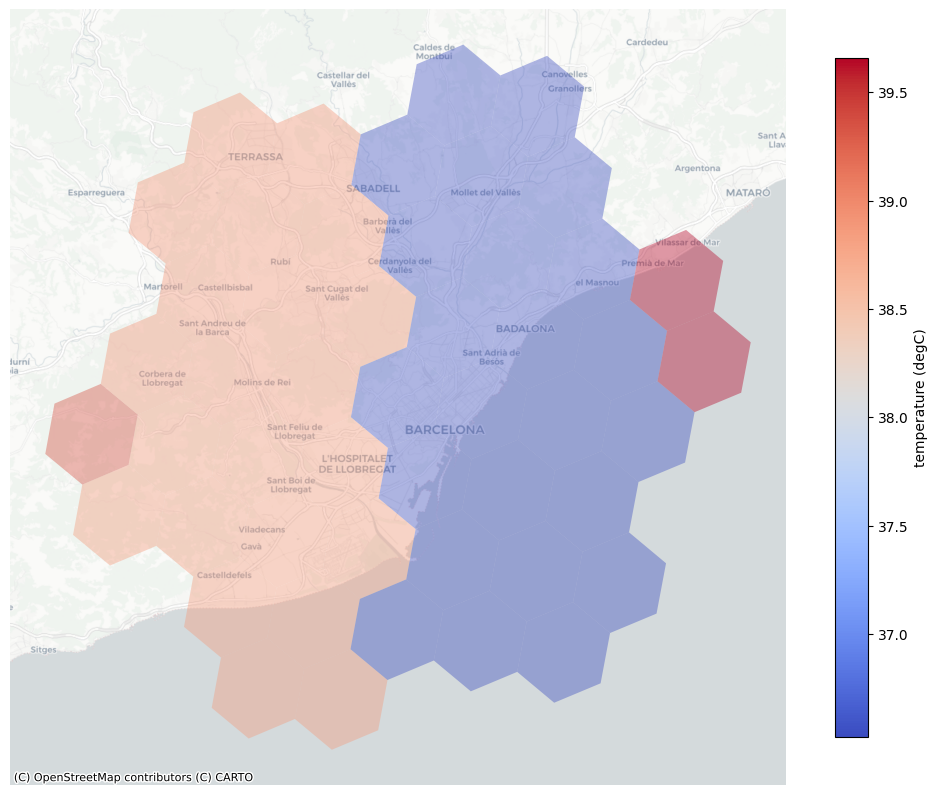

In [14]:
# Plot
fig, ax = plt.subplots(figsize=(10, 10))

df_web_mercator = df.to_crs(epsg=3857)

df_web_mercator.plot(
    column="value",
    ax=ax,
    legend=True,
    cmap='coolwarm',
    edgecolor=None,
    alpha=0.4,
    legend_kwds={'label': f"temperature (degC)", 'shrink': 0.7},
)
contextily.add_basemap(ax, source=contextily.providers.CartoDB.Positron)

ax.set_axis_off()
plt.tight_layout()
plt.show()